In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

In [3]:
dataset_url = 'https://www.kaggle.com/ikarus777/best-artworks-of-all-time'

用户名和密码见 kaggle.json

In [4]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 

 type0factor


Your Kaggle Key: 

 ···································································


  0%|          | 0.00/2.29G [00:00<?, ?B/s]

100%|██████████| 2.29G/2.29G [03:23<00:00, 12.1MB/s]


In [5]:
data_dir = './best-artworks-of-all-time/resized/'

In [6]:
import os

In [7]:
for cls in os.listdir(data_dir):
    print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

resized : 8683


In [8]:
from torchvision.datasets import ImageFolder

In [9]:
dataset = ImageFolder(data_dir)

In [10]:
len(dataset)

8683

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

#Let's see some of art pictures present in dataset.

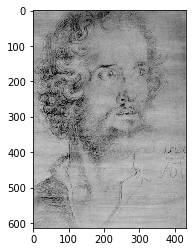

In [12]:
img, label = dataset[0]
plt.imshow(img)

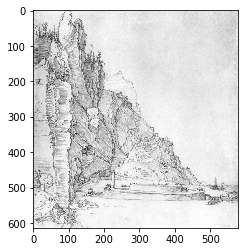

In [13]:
img, label = dataset[500]
plt.imshow(img)

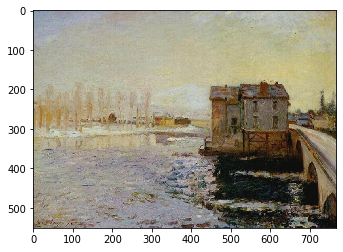

In [14]:
img, label = dataset[741]
plt.imshow(img)

#Making batches of picture:

1.   First I'll resize and center crop all images to ensure that they are all in same shape and size.

2. Then convert them to tensors and normalize them.
3. Then create the data loader.
4. Then look at some samples.



In [15]:
import torchvision.transforms as tt
from torch.utils.data import DataLoader

In [16]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [17]:
train_ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [18]:
from torchvision.utils import make_grid

In [19]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [20]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

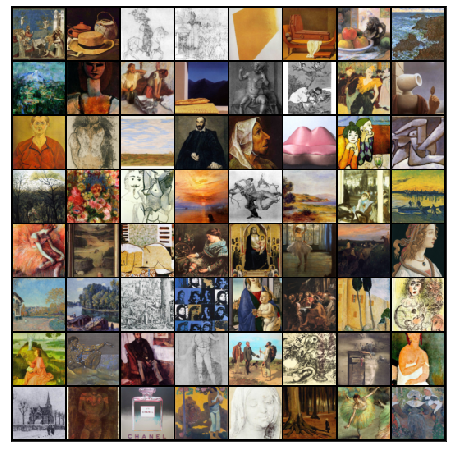

In [21]:
show_batch(train_dl)

#Using a GPU
To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class "DeviceDataLoader" to move our model & data to the GPU, if one is available.

In [22]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
import torch

In [24]:
device = get_default_device()
device

device(type='cuda')

In [25]:
train_dl = DeviceDataLoader(train_dl, device)

#Discriminator Network
The discriminator takes  image as an input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

In [26]:
import torch.nn as nn

In [27]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [28]:
discriminator = to_device(discriminator, device)

#Generator Network
The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution)

In [29]:
latent_size = 128

In [30]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

#Let's see how our first generative image look's like .

torch.Size([128, 3, 64, 64])


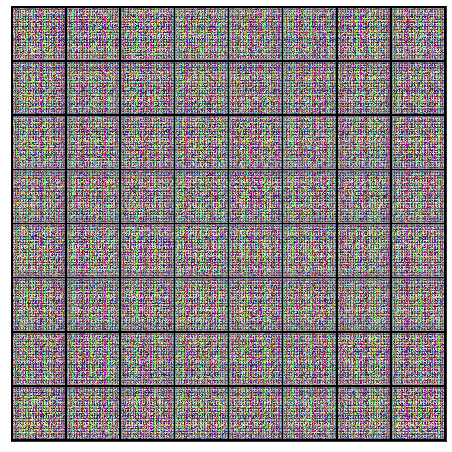

In [31]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

It seems like it's really poor.So for that now we have to train our model.

In [32]:
generator = to_device(generator, device)

#Discriminator Training
Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

###Here are the steps involved in training the discriminator.

1. We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

2. We first pass a batch of real images, and compute the loss, setting the target labels to 1.

3. Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

4. Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (opt_d only affects the discriminator.parameters())

In [33]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

#Generator Training
Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

1. We generate a batch of images using the generator, pass it into the discriminator.

2. We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

3. We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [34]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [35]:
from torchvision.utils import save_image

In [36]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [37]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [38]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


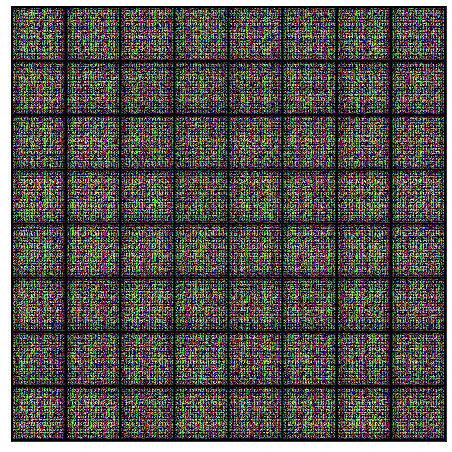

In [39]:
save_samples(0, fixed_latent)


## Full Training Loop

Let's define a fit function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>


In [40]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [41]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [42]:
lr = 0.0002
epochs = 300

In [44]:
history = fit(epochs, lr)


Epoch [1/300], loss_g: 4.1012, loss_d: 0.4241, real_score: 0.7386, fake_score: 0.0738
Saving generated-images-0001.png



Epoch [2/300], loss_g: 4.3480, loss_d: 0.4816, real_score: 0.9011, fake_score: 0.2842
Saving generated-images-0002.png



Epoch [3/300], loss_g: 3.2007, loss_d: 0.8841, real_score: 0.5047, fake_score: 0.0263
Saving generated-images-0003.png



Epoch [4/300], loss_g: 3.0092, loss_d: 0.4207, real_score: 0.8997, fake_score: 0.2332
Saving generated-images-0004.png



Epoch [5/300], loss_g: 3.2467, loss_d: 0.3523, real_score: 0.7698, fake_score: 0.0678
Saving generated-images-0005.png



Epoch [6/300], loss_g: 4.5660, loss_d: 0.3228, real_score: 0.9008, fake_score: 0.1791
Saving generated-images-0006.png



Epoch [7/300], loss_g: 2.9438, loss_d: 0.4581, real_score: 0.7195, fake_score: 0.0817
Saving generated-images-0007.png



Epoch [8/300], loss_g: 1.7258, loss_d: 0.8257, real_score: 0.5263, fake_score: 0.0479
Saving generated-images-0008.png



Epoch [9/300], loss_g: 4.4179, loss_d: 0.5618, real_score: 0.8414, fake_score: 0.2735
Saving generated-images-0009.png



Epoch [10/300], loss_g: 5.2451, loss_d: 0.7741, real_score: 0.8460, fake_score: 0.4090
Saving generated-images-0010.png



Epoch [11/300], loss_g: 4.1879, loss_d: 0.3779, real_score: 0.8669, fake_score: 0.1867
Saving generated-images-0011.png



Epoch [12/300], loss_g: 3.9359, loss_d: 0.3010, real_score: 0.8710, fake_score: 0.1318
Saving generated-images-0012.png



Epoch [13/300], loss_g: 4.7505, loss_d: 0.2410, real_score: 0.8611, fake_score: 0.0739
Saving generated-images-0013.png



Epoch [14/300], loss_g: 4.5362, loss_d: 0.3528, real_score: 0.7747, fake_score: 0.0674
Saving generated-images-0014.png



Epoch [15/300], loss_g: 2.5575, loss_d: 0.4074, real_score: 0.7501, fake_score: 0.0640
Saving generated-images-0015.png



Epoch [16/300], loss_g: 1.4021, loss_d: 0.9147, real_score: 0.4882, fake_score: 0.0616
Saving generated-images-0016.png



Epoch [17/300], loss_g: 4.3612, loss_d: 0.3729, real_score: 0.9060, fake_score: 0.2175
Saving generated-images-0017.png



Epoch [18/300], loss_g: 6.6258, loss_d: 0.8204, real_score: 0.9612, fake_score: 0.4843
Saving generated-images-0018.png



Epoch [19/300], loss_g: 4.2705, loss_d: 0.1241, real_score: 0.9409, fake_score: 0.0587
Saving generated-images-0019.png



Epoch [20/300], loss_g: 4.0457, loss_d: 0.2895, real_score: 0.9088, fake_score: 0.1565
Saving generated-images-0020.png



Epoch [21/300], loss_g: 5.4312, loss_d: 0.4666, real_score: 0.9879, fake_score: 0.3293
Saving generated-images-0021.png



Epoch [22/300], loss_g: 5.0104, loss_d: 0.4643, real_score: 0.9677, fake_score: 0.3133
Saving generated-images-0022.png



Epoch [23/300], loss_g: 3.1882, loss_d: 0.2271, real_score: 0.8911, fake_score: 0.0914
Saving generated-images-0023.png



Epoch [24/300], loss_g: 2.6724, loss_d: 0.3027, real_score: 0.7868, fake_score: 0.0372
Saving generated-images-0024.png



Epoch [25/300], loss_g: 4.3424, loss_d: 0.5348, real_score: 0.7661, fake_score: 0.1880
Saving generated-images-0025.png



Epoch [26/300], loss_g: 4.9692, loss_d: 0.4231, real_score: 0.9613, fake_score: 0.2907
Saving generated-images-0026.png



Epoch [27/300], loss_g: 3.8443, loss_d: 0.2761, real_score: 0.8593, fake_score: 0.1003
Saving generated-images-0027.png



Epoch [28/300], loss_g: 4.2980, loss_d: 0.4520, real_score: 0.9548, fake_score: 0.2968
Saving generated-images-0028.png



Epoch [29/300], loss_g: 5.2714, loss_d: 0.5554, real_score: 0.8378, fake_score: 0.2744
Saving generated-images-0029.png



Epoch [30/300], loss_g: 4.2572, loss_d: 0.3007, real_score: 0.8989, fake_score: 0.1624
Saving generated-images-0030.png



Epoch [31/300], loss_g: 2.0992, loss_d: 0.4929, real_score: 0.6794, fake_score: 0.0568
Saving generated-images-0031.png



Epoch [32/300], loss_g: 5.6150, loss_d: 0.2256, real_score: 0.9458, fake_score: 0.1434
Saving generated-images-0032.png



Epoch [33/300], loss_g: 4.7658, loss_d: 0.2695, real_score: 0.9396, fake_score: 0.1758
Saving generated-images-0033.png



Epoch [34/300], loss_g: 4.5980, loss_d: 0.4253, real_score: 0.9355, fake_score: 0.2682
Saving generated-images-0034.png



Epoch [35/300], loss_g: 2.6811, loss_d: 0.4019, real_score: 0.7092, fake_score: 0.0230
Saving generated-images-0035.png



Epoch [36/300], loss_g: 3.4353, loss_d: 0.2392, real_score: 0.8962, fake_score: 0.1072
Saving generated-images-0036.png



Epoch [37/300], loss_g: 2.4576, loss_d: 1.3912, real_score: 0.3126, fake_score: 0.0009
Saving generated-images-0037.png



Epoch [38/300], loss_g: 5.6164, loss_d: 0.3647, real_score: 0.7239, fake_score: 0.0034
Saving generated-images-0038.png



Epoch [39/300], loss_g: 4.3006, loss_d: 0.3076, real_score: 0.9554, fake_score: 0.2114
Saving generated-images-0039.png



Epoch [40/300], loss_g: 2.7444, loss_d: 0.2863, real_score: 0.8063, fake_score: 0.0442
Saving generated-images-0040.png



Epoch [41/300], loss_g: 3.9862, loss_d: 0.1880, real_score: 0.9430, fake_score: 0.1094
Saving generated-images-0041.png



Epoch [42/300], loss_g: 1.5265, loss_d: 0.4737, real_score: 0.6627, fake_score: 0.0159
Saving generated-images-0042.png



Epoch [43/300], loss_g: 3.8597, loss_d: 0.1913, real_score: 0.9130, fake_score: 0.0889
Saving generated-images-0043.png



Epoch [44/300], loss_g: 5.5847, loss_d: 0.1227, real_score: 0.9655, fake_score: 0.0787
Saving generated-images-0044.png



Epoch [45/300], loss_g: 3.0163, loss_d: 0.2604, real_score: 0.8659, fake_score: 0.0853
Saving generated-images-0045.png



Epoch [46/300], loss_g: 3.5015, loss_d: 0.4170, real_score: 0.7056, fake_score: 0.0108
Saving generated-images-0046.png



Epoch [47/300], loss_g: 4.9058, loss_d: 0.6692, real_score: 0.9858, fake_score: 0.4292
Saving generated-images-0047.png



Epoch [48/300], loss_g: 4.6231, loss_d: 0.3548, real_score: 0.7914, fake_score: 0.0777
Saving generated-images-0048.png



Epoch [49/300], loss_g: 4.4998, loss_d: 0.2522, real_score: 0.9644, fake_score: 0.1808
Saving generated-images-0049.png



Epoch [50/300], loss_g: 1.5998, loss_d: 0.6948, real_score: 0.5603, fake_score: 0.0143
Saving generated-images-0050.png



Epoch [51/300], loss_g: 1.9279, loss_d: 2.7599, real_score: 0.1002, fake_score: 0.0001
Saving generated-images-0051.png



Epoch [52/300], loss_g: 2.8757, loss_d: 0.3900, real_score: 0.8995, fake_score: 0.2263
Saving generated-images-0052.png



Epoch [53/300], loss_g: 5.2120, loss_d: 0.2397, real_score: 0.9412, fake_score: 0.1532
Saving generated-images-0053.png



Epoch [54/300], loss_g: 4.0290, loss_d: 0.2419, real_score: 0.9910, fake_score: 0.1919
Saving generated-images-0054.png



Epoch [55/300], loss_g: 3.0759, loss_d: 0.1597, real_score: 0.9928, fake_score: 0.1327
Saving generated-images-0055.png



Epoch [56/300], loss_g: 3.0860, loss_d: 0.2679, real_score: 0.9563, fake_score: 0.1825
Saving generated-images-0056.png



Epoch [57/300], loss_g: 4.5987, loss_d: 0.1918, real_score: 0.9864, fake_score: 0.1498
Saving generated-images-0057.png



Epoch [58/300], loss_g: 3.8684, loss_d: 0.3074, real_score: 0.9776, fake_score: 0.2234
Saving generated-images-0058.png



Epoch [59/300], loss_g: 5.2289, loss_d: 0.8001, real_score: 0.9601, fake_score: 0.4702
Saving generated-images-0059.png



Epoch [60/300], loss_g: 3.7141, loss_d: 0.1659, real_score: 0.9661, fake_score: 0.1139
Saving generated-images-0060.png



Epoch [61/300], loss_g: 7.5650, loss_d: 1.3330, real_score: 0.9807, fake_score: 0.6364
Saving generated-images-0061.png



Epoch [62/300], loss_g: 4.8653, loss_d: 0.3254, real_score: 0.9654, fake_score: 0.2244
Saving generated-images-0062.png



Epoch [63/300], loss_g: 7.2631, loss_d: 1.1307, real_score: 0.9953, fake_score: 0.6079
Saving generated-images-0063.png



Epoch [64/300], loss_g: 8.1931, loss_d: 1.5793, real_score: 0.9915, fake_score: 0.7061
Saving generated-images-0064.png



Epoch [65/300], loss_g: 4.0546, loss_d: 0.3795, real_score: 0.9591, fake_score: 0.2570
Saving generated-images-0065.png



Epoch [66/300], loss_g: 4.0051, loss_d: 0.1327, real_score: 0.9560, fake_score: 0.0797
Saving generated-images-0066.png



Epoch [67/300], loss_g: 2.3978, loss_d: 0.6292, real_score: 0.5929, fake_score: 0.0268
Saving generated-images-0067.png



Epoch [68/300], loss_g: 5.5836, loss_d: 0.1011, real_score: 0.9490, fake_score: 0.0443
Saving generated-images-0068.png



Epoch [69/300], loss_g: 4.0885, loss_d: 0.4712, real_score: 0.9741, fake_score: 0.3174
Saving generated-images-0069.png



Epoch [70/300], loss_g: 5.5979, loss_d: 0.0847, real_score: 0.9440, fake_score: 0.0236
Saving generated-images-0070.png



Epoch [71/300], loss_g: 3.3899, loss_d: 0.1667, real_score: 0.9107, fake_score: 0.0643
Saving generated-images-0071.png



Epoch [72/300], loss_g: 3.5445, loss_d: 1.3819, real_score: 0.5376, fake_score: 0.1620
Saving generated-images-0072.png



Epoch [73/300], loss_g: 3.0371, loss_d: 0.4015, real_score: 0.8929, fake_score: 0.2229
Saving generated-images-0073.png



Epoch [74/300], loss_g: 5.6886, loss_d: 1.0237, real_score: 0.9965, fake_score: 0.5639
Saving generated-images-0074.png



Epoch [75/300], loss_g: 3.4811, loss_d: 0.3169, real_score: 0.9824, fake_score: 0.2268
Saving generated-images-0075.png



Epoch [76/300], loss_g: 3.9394, loss_d: 0.1663, real_score: 0.8802, fake_score: 0.0295
Saving generated-images-0076.png



Epoch [77/300], loss_g: 3.5201, loss_d: 0.2147, real_score: 0.9402, fake_score: 0.1254
Saving generated-images-0077.png



Epoch [78/300], loss_g: 6.7490, loss_d: 0.1393, real_score: 0.9412, fake_score: 0.0672
Saving generated-images-0078.png



Epoch [79/300], loss_g: 2.5556, loss_d: 0.1543, real_score: 0.9606, fake_score: 0.0980
Saving generated-images-0079.png



Epoch [80/300], loss_g: 4.1859, loss_d: 0.3243, real_score: 0.8638, fake_score: 0.1380
Saving generated-images-0080.png



Epoch [81/300], loss_g: 2.5934, loss_d: 0.3151, real_score: 0.9012, fake_score: 0.1691
Saving generated-images-0081.png



Epoch [82/300], loss_g: 4.1415, loss_d: 0.2305, real_score: 0.9471, fake_score: 0.1395
Saving generated-images-0082.png



Epoch [83/300], loss_g: 4.3555, loss_d: 0.0663, real_score: 0.9821, fake_score: 0.0449
Saving generated-images-0083.png



Epoch [84/300], loss_g: 3.4690, loss_d: 0.1886, real_score: 0.8932, fake_score: 0.0641
Saving generated-images-0084.png



Epoch [85/300], loss_g: 3.7496, loss_d: 0.2009, real_score: 0.9584, fake_score: 0.1363
Saving generated-images-0085.png



Epoch [86/300], loss_g: 4.9453, loss_d: 0.4263, real_score: 0.8644, fake_score: 0.2020
Saving generated-images-0086.png



Epoch [87/300], loss_g: 3.7204, loss_d: 0.2345, real_score: 0.8379, fake_score: 0.0418
Saving generated-images-0087.png



Epoch [88/300], loss_g: 1.2792, loss_d: 0.4147, real_score: 0.7337, fake_score: 0.0672
Saving generated-images-0088.png



Epoch [89/300], loss_g: 3.4606, loss_d: 0.3751, real_score: 0.7165, fake_score: 0.0028
Saving generated-images-0089.png



Epoch [90/300], loss_g: 3.6978, loss_d: 0.2382, real_score: 0.8641, fake_score: 0.0564
Saving generated-images-0090.png



Epoch [91/300], loss_g: 5.0432, loss_d: 0.4186, real_score: 0.8870, fake_score: 0.2167
Saving generated-images-0091.png



Epoch [92/300], loss_g: 2.7118, loss_d: 0.2699, real_score: 0.8150, fake_score: 0.0434
Saving generated-images-0092.png



Epoch [93/300], loss_g: 3.6577, loss_d: 0.2485, real_score: 0.8746, fake_score: 0.0943
Saving generated-images-0093.png



Epoch [94/300], loss_g: 3.7709, loss_d: 0.1544, real_score: 0.8833, fake_score: 0.0227
Saving generated-images-0094.png



Epoch [95/300], loss_g: 2.3323, loss_d: 0.6527, real_score: 0.5705, fake_score: 0.0049
Saving generated-images-0095.png



Epoch [96/300], loss_g: 3.5962, loss_d: 0.2191, real_score: 0.8827, fake_score: 0.0750
Saving generated-images-0096.png



Epoch [97/300], loss_g: 2.3289, loss_d: 0.3528, real_score: 0.7506, fake_score: 0.0213
Saving generated-images-0097.png



Epoch [98/300], loss_g: 4.1128, loss_d: 0.0350, real_score: 0.9902, fake_score: 0.0244
Saving generated-images-0098.png



Epoch [99/300], loss_g: 3.7215, loss_d: 0.1711, real_score: 0.9645, fake_score: 0.1179
Saving generated-images-0099.png



Epoch [100/300], loss_g: 3.4349, loss_d: 0.5326, real_score: 0.8087, fake_score: 0.2144
Saving generated-images-0100.png



Epoch [101/300], loss_g: 4.3501, loss_d: 0.3003, real_score: 0.9731, fake_score: 0.2149
Saving generated-images-0101.png



Epoch [102/300], loss_g: 4.1687, loss_d: 0.3044, real_score: 0.7778, fake_score: 0.0250
Saving generated-images-0102.png



Epoch [103/300], loss_g: 4.1984, loss_d: 0.2589, real_score: 0.9679, fake_score: 0.1831
Saving generated-images-0103.png



Epoch [104/300], loss_g: 4.2739, loss_d: 0.0582, real_score: 0.9853, fake_score: 0.0405
Saving generated-images-0104.png



Epoch [105/300], loss_g: 4.4500, loss_d: 0.2888, real_score: 0.9238, fake_score: 0.1637
Saving generated-images-0105.png



Epoch [106/300], loss_g: 5.7477, loss_d: 0.3485, real_score: 0.9830, fake_score: 0.2461
Saving generated-images-0106.png



Epoch [107/300], loss_g: 5.4990, loss_d: 0.0853, real_score: 0.9486, fake_score: 0.0296
Saving generated-images-0107.png



Epoch [108/300], loss_g: 4.7152, loss_d: 0.1818, real_score: 0.9008, fake_score: 0.0577
Saving generated-images-0108.png



Epoch [109/300], loss_g: 3.1852, loss_d: 0.2793, real_score: 0.8847, fake_score: 0.1286
Saving generated-images-0109.png



Epoch [110/300], loss_g: 4.3784, loss_d: 0.0684, real_score: 0.9896, fake_score: 0.0535
Saving generated-images-0110.png



Epoch [111/300], loss_g: 4.5436, loss_d: 0.0979, real_score: 0.9564, fake_score: 0.0489
Saving generated-images-0111.png



Epoch [112/300], loss_g: 4.1291, loss_d: 0.2145, real_score: 0.9918, fake_score: 0.1724
Saving generated-images-0112.png



Epoch [113/300], loss_g: 3.1377, loss_d: 0.2843, real_score: 0.7743, fake_score: 0.0064
Saving generated-images-0113.png



Epoch [114/300], loss_g: 5.8931, loss_d: 0.1975, real_score: 0.9933, fake_score: 0.1623
Saving generated-images-0114.png



Epoch [115/300], loss_g: 4.2516, loss_d: 0.0744, real_score: 0.9849, fake_score: 0.0557
Saving generated-images-0115.png



Epoch [116/300], loss_g: 6.6172, loss_d: 1.2714, real_score: 0.9969, fake_score: 0.5841
Saving generated-images-0116.png



Epoch [117/300], loss_g: 1.3271, loss_d: 1.0405, real_score: 0.4815, fake_score: 0.0068
Saving generated-images-0117.png



Epoch [118/300], loss_g: 3.6944, loss_d: 0.1424, real_score: 0.9873, fake_score: 0.1074
Saving generated-images-0118.png



Epoch [119/300], loss_g: 2.2909, loss_d: 0.2227, real_score: 0.8674, fake_score: 0.0641
Saving generated-images-0119.png



Epoch [120/300], loss_g: 4.8710, loss_d: 0.1813, real_score: 0.9988, fake_score: 0.1526
Saving generated-images-0120.png



Epoch [121/300], loss_g: 4.3320, loss_d: 0.1275, real_score: 0.9865, fake_score: 0.1005
Saving generated-images-0121.png



Epoch [122/300], loss_g: 1.2765, loss_d: 0.6637, real_score: 0.5815, fake_score: 0.0141
Saving generated-images-0122.png



Epoch [123/300], loss_g: 4.2064, loss_d: 0.1421, real_score: 0.9305, fake_score: 0.0623
Saving generated-images-0123.png



Epoch [124/300], loss_g: 3.4574, loss_d: 0.1222, real_score: 0.9921, fake_score: 0.1015
Saving generated-images-0124.png



Epoch [125/300], loss_g: 3.6252, loss_d: 0.1244, real_score: 0.9051, fake_score: 0.0183
Saving generated-images-0125.png



Epoch [126/300], loss_g: 4.8670, loss_d: 0.0636, real_score: 0.9732, fake_score: 0.0340
Saving generated-images-0126.png



Epoch [127/300], loss_g: 1.5356, loss_d: 0.3490, real_score: 0.7459, fake_score: 0.0093
Saving generated-images-0127.png



Epoch [128/300], loss_g: 4.7633, loss_d: 0.2923, real_score: 0.9525, fake_score: 0.1744
Saving generated-images-0128.png



Epoch [129/300], loss_g: 4.2738, loss_d: 0.1399, real_score: 0.9458, fake_score: 0.0743
Saving generated-images-0129.png



Epoch [130/300], loss_g: 4.4801, loss_d: 0.0890, real_score: 0.9636, fake_score: 0.0482
Saving generated-images-0130.png



Epoch [131/300], loss_g: 4.4382, loss_d: 0.0707, real_score: 0.9895, fake_score: 0.0560
Saving generated-images-0131.png



Epoch [132/300], loss_g: 3.6064, loss_d: 0.1346, real_score: 0.9834, fake_score: 0.1024
Saving generated-images-0132.png



Epoch [133/300], loss_g: 4.0122, loss_d: 0.0923, real_score: 0.9385, fake_score: 0.0267
Saving generated-images-0133.png



Epoch [134/300], loss_g: 5.0821, loss_d: 0.0569, real_score: 0.9973, fake_score: 0.0503
Saving generated-images-0134.png



Epoch [135/300], loss_g: 5.8897, loss_d: 0.0631, real_score: 0.9811, fake_score: 0.0415
Saving generated-images-0135.png



Epoch [136/300], loss_g: 3.7580, loss_d: 0.0892, real_score: 0.9237, fake_score: 0.0073
Saving generated-images-0136.png



Epoch [137/300], loss_g: 0.8841, loss_d: 3.1602, real_score: 0.2120, fake_score: 0.0992
Saving generated-images-0137.png



Epoch [138/300], loss_g: 3.1941, loss_d: 0.5528, real_score: 0.9555, fake_score: 0.3115
Saving generated-images-0138.png



Epoch [139/300], loss_g: 4.0781, loss_d: 0.1221, real_score: 0.9809, fake_score: 0.0897
Saving generated-images-0139.png



Epoch [140/300], loss_g: 5.1913, loss_d: 0.0831, real_score: 0.9815, fake_score: 0.0589
Saving generated-images-0140.png



Epoch [141/300], loss_g: 4.6655, loss_d: 0.1508, real_score: 0.9355, fake_score: 0.0681
Saving generated-images-0141.png



Epoch [142/300], loss_g: 2.4758, loss_d: 0.2475, real_score: 0.8258, fake_score: 0.0274
Saving generated-images-0142.png



Epoch [143/300], loss_g: 4.7894, loss_d: 0.0963, real_score: 0.9585, fake_score: 0.0489
Saving generated-images-0143.png



Epoch [144/300], loss_g: 3.5091, loss_d: 0.0889, real_score: 0.9670, fake_score: 0.0494
Saving generated-images-0144.png



Epoch [145/300], loss_g: 4.0072, loss_d: 0.1941, real_score: 0.8536, fake_score: 0.0251
Saving generated-images-0145.png



Epoch [146/300], loss_g: 5.1339, loss_d: 0.0475, real_score: 0.9676, fake_score: 0.0140
Saving generated-images-0146.png



Epoch [147/300], loss_g: 1.8145, loss_d: 0.3629, real_score: 0.7227, fake_score: 0.0134
Saving generated-images-0147.png



Epoch [148/300], loss_g: 5.1714, loss_d: 0.0682, real_score: 0.9993, fake_score: 0.0620
Saving generated-images-0148.png



Epoch [149/300], loss_g: 4.3386, loss_d: 0.1135, real_score: 0.9712, fake_score: 0.0748
Saving generated-images-0149.png



Epoch [150/300], loss_g: 4.6542, loss_d: 0.1400, real_score: 0.9987, fake_score: 0.1161
Saving generated-images-0150.png



Epoch [151/300], loss_g: 5.7982, loss_d: 0.0865, real_score: 0.9302, fake_score: 0.0075
Saving generated-images-0151.png



Epoch [152/300], loss_g: 5.1425, loss_d: 0.0313, real_score: 0.9917, fake_score: 0.0222
Saving generated-images-0152.png



Epoch [153/300], loss_g: 4.3998, loss_d: 0.1053, real_score: 0.9082, fake_score: 0.0060
Saving generated-images-0153.png



Epoch [154/300], loss_g: 1.8259, loss_d: 0.2014, real_score: 0.8689, fake_score: 0.0371
Saving generated-images-0154.png



Epoch [155/300], loss_g: 3.9772, loss_d: 0.3050, real_score: 0.9936, fake_score: 0.2165
Saving generated-images-0155.png



Epoch [156/300], loss_g: 4.5438, loss_d: 0.1233, real_score: 0.9366, fake_score: 0.0475
Saving generated-images-0156.png



Epoch [157/300], loss_g: 4.0303, loss_d: 0.0822, real_score: 0.9624, fake_score: 0.0402
Saving generated-images-0157.png



Epoch [158/300], loss_g: 2.6922, loss_d: 0.2009, real_score: 0.8551, fake_score: 0.0298
Saving generated-images-0158.png



Epoch [159/300], loss_g: 3.0058, loss_d: 0.1775, real_score: 0.8625, fake_score: 0.0170
Saving generated-images-0159.png



Epoch [160/300], loss_g: 5.7839, loss_d: 0.1412, real_score: 0.9976, fake_score: 0.1223
Saving generated-images-0160.png



Epoch [161/300], loss_g: 3.5926, loss_d: 0.0363, real_score: 0.9883, fake_score: 0.0238
Saving generated-images-0161.png



Epoch [162/300], loss_g: 4.4466, loss_d: 0.0550, real_score: 0.9961, fake_score: 0.0483
Saving generated-images-0162.png



Epoch [163/300], loss_g: 4.9498, loss_d: 0.0491, real_score: 0.9936, fake_score: 0.0407
Saving generated-images-0163.png



Epoch [164/300], loss_g: 4.8187, loss_d: 0.0439, real_score: 0.9820, fake_score: 0.0244
Saving generated-images-0164.png



Epoch [165/300], loss_g: 5.5037, loss_d: 0.0493, real_score: 0.9958, fake_score: 0.0429
Saving generated-images-0165.png



Epoch [166/300], loss_g: 5.4199, loss_d: 0.0285, real_score: 0.9834, fake_score: 0.0114
Saving generated-images-0166.png



Epoch [167/300], loss_g: 5.1169, loss_d: 0.0470, real_score: 0.9751, fake_score: 0.0210
Saving generated-images-0167.png



Epoch [168/300], loss_g: 2.6296, loss_d: 1.8366, real_score: 0.7310, fake_score: 0.5238
Saving generated-images-0168.png



Epoch [169/300], loss_g: 4.9162, loss_d: 0.7882, real_score: 0.9322, fake_score: 0.3893
Saving generated-images-0169.png



Epoch [170/300], loss_g: 2.2369, loss_d: 0.5380, real_score: 0.7420, fake_score: 0.1005
Saving generated-images-0170.png



Epoch [171/300], loss_g: 3.4192, loss_d: 0.2839, real_score: 0.8409, fake_score: 0.0780
Saving generated-images-0171.png



Epoch [172/300], loss_g: 4.4812, loss_d: 0.1133, real_score: 0.9769, fake_score: 0.0794
Saving generated-images-0172.png



Epoch [173/300], loss_g: 3.5639, loss_d: 0.1666, real_score: 0.8894, fake_score: 0.0360
Saving generated-images-0173.png



Epoch [174/300], loss_g: 4.0865, loss_d: 0.0807, real_score: 0.9808, fake_score: 0.0560
Saving generated-images-0174.png



Epoch [175/300], loss_g: 4.0574, loss_d: 0.0977, real_score: 0.9345, fake_score: 0.0268
Saving generated-images-0175.png



Epoch [176/300], loss_g: 3.3467, loss_d: 0.0540, real_score: 0.9685, fake_score: 0.0207
Saving generated-images-0176.png



Epoch [177/300], loss_g: 4.7327, loss_d: 0.0249, real_score: 0.9961, fake_score: 0.0204
Saving generated-images-0177.png



Epoch [178/300], loss_g: 4.5935, loss_d: 0.0752, real_score: 0.9975, fake_score: 0.0662
Saving generated-images-0178.png



Epoch [179/300], loss_g: 3.8534, loss_d: 0.0711, real_score: 0.9544, fake_score: 0.0228
Saving generated-images-0179.png



Epoch [180/300], loss_g: 4.9278, loss_d: 0.2842, real_score: 0.9091, fake_score: 0.1449
Saving generated-images-0180.png



Epoch [181/300], loss_g: 4.0707, loss_d: 0.1254, real_score: 0.9495, fake_score: 0.0642
Saving generated-images-0181.png



Epoch [182/300], loss_g: 4.3345, loss_d: 0.0934, real_score: 0.9712, fake_score: 0.0594
Saving generated-images-0182.png



Epoch [183/300], loss_g: 4.6289, loss_d: 0.0265, real_score: 0.9954, fake_score: 0.0213
Saving generated-images-0183.png



Epoch [184/300], loss_g: 5.3273, loss_d: 0.0168, real_score: 0.9968, fake_score: 0.0133
Saving generated-images-0184.png



Epoch [185/300], loss_g: 5.1517, loss_d: 0.0608, real_score: 0.9588, fake_score: 0.0172
Saving generated-images-0185.png



Epoch [186/300], loss_g: 5.5621, loss_d: 0.0483, real_score: 0.9841, fake_score: 0.0305
Saving generated-images-0186.png



Epoch [187/300], loss_g: 5.6282, loss_d: 0.0248, real_score: 0.9909, fake_score: 0.0153
Saving generated-images-0187.png



Epoch [188/300], loss_g: 5.2704, loss_d: 0.0325, real_score: 0.9836, fake_score: 0.0154
Saving generated-images-0188.png



Epoch [189/300], loss_g: 5.8995, loss_d: 0.0222, real_score: 0.9982, fake_score: 0.0198
Saving generated-images-0189.png



Epoch [190/300], loss_g: 5.2719, loss_d: 0.0619, real_score: 0.9727, fake_score: 0.0318
Saving generated-images-0190.png



Epoch [191/300], loss_g: 5.7009, loss_d: 1.7829, real_score: 0.9037, fake_score: 0.6943
Saving generated-images-0191.png



Epoch [192/300], loss_g: 3.3390, loss_d: 0.3017, real_score: 0.8499, fake_score: 0.0880
Saving generated-images-0192.png



Epoch [193/300], loss_g: 4.0429, loss_d: 0.1680, real_score: 0.9035, fake_score: 0.0544
Saving generated-images-0193.png



Epoch [194/300], loss_g: 4.9177, loss_d: 0.1558, real_score: 0.9197, fake_score: 0.0535
Saving generated-images-0194.png



Epoch [195/300], loss_g: 4.5880, loss_d: 0.1126, real_score: 0.9300, fake_score: 0.0334
Saving generated-images-0195.png



Epoch [196/300], loss_g: 4.9788, loss_d: 0.1039, real_score: 0.9566, fake_score: 0.0425
Saving generated-images-0196.png



Epoch [197/300], loss_g: 4.7971, loss_d: 0.0543, real_score: 0.9747, fake_score: 0.0271
Saving generated-images-0197.png



Epoch [198/300], loss_g: 4.8585, loss_d: 0.0776, real_score: 0.9886, fake_score: 0.0592
Saving generated-images-0198.png



Epoch [199/300], loss_g: 6.0554, loss_d: 0.0369, real_score: 0.9905, fake_score: 0.0264
Saving generated-images-0199.png



Epoch [200/300], loss_g: 4.2172, loss_d: 0.0661, real_score: 0.9581, fake_score: 0.0214
Saving generated-images-0200.png



Epoch [201/300], loss_g: 5.8186, loss_d: 0.0302, real_score: 0.9990, fake_score: 0.0255
Saving generated-images-0201.png



Epoch [202/300], loss_g: 4.6648, loss_d: 0.0399, real_score: 0.9831, fake_score: 0.0220
Saving generated-images-0202.png



Epoch [203/300], loss_g: 5.1929, loss_d: 0.0494, real_score: 0.9828, fake_score: 0.0308
Saving generated-images-0203.png



Epoch [204/300], loss_g: 5.5220, loss_d: 0.0305, real_score: 0.9930, fake_score: 0.0227
Saving generated-images-0204.png



Epoch [205/300], loss_g: 3.8670, loss_d: 0.0935, real_score: 0.9947, fake_score: 0.0807
Saving generated-images-0205.png



Epoch [206/300], loss_g: 3.3009, loss_d: 0.4846, real_score: 0.8595, fake_score: 0.2012
Saving generated-images-0206.png



Epoch [207/300], loss_g: 4.1476, loss_d: 0.2115, real_score: 0.9123, fake_score: 0.0935
Saving generated-images-0207.png



Epoch [208/300], loss_g: 3.5443, loss_d: 0.1500, real_score: 0.8993, fake_score: 0.0335
Saving generated-images-0208.png



Epoch [209/300], loss_g: 5.6671, loss_d: 0.0259, real_score: 0.9859, fake_score: 0.0109
Saving generated-images-0209.png



Epoch [210/300], loss_g: 6.0732, loss_d: 0.0195, real_score: 0.9888, fake_score: 0.0081
Saving generated-images-0210.png



Epoch [211/300], loss_g: 5.3765, loss_d: 0.0474, real_score: 0.9981, fake_score: 0.0430
Saving generated-images-0211.png



Epoch [212/300], loss_g: 5.1755, loss_d: 0.0162, real_score: 0.9943, fake_score: 0.0103
Saving generated-images-0212.png



Epoch [213/300], loss_g: 4.2823, loss_d: 0.0222, real_score: 0.9924, fake_score: 0.0143
Saving generated-images-0213.png



Epoch [214/300], loss_g: 4.5037, loss_d: 0.0715, real_score: 0.9434, fake_score: 0.0114
Saving generated-images-0214.png



Epoch [215/300], loss_g: 0.0704, loss_d: 4.0800, real_score: 0.0871, fake_score: 0.0003
Saving generated-images-0215.png



Epoch [216/300], loss_g: 4.8821, loss_d: 0.4942, real_score: 0.9555, fake_score: 0.2762
Saving generated-images-0216.png



Epoch [217/300], loss_g: 2.4726, loss_d: 0.2187, real_score: 0.8581, fake_score: 0.0456
Saving generated-images-0217.png



Epoch [218/300], loss_g: 3.9345, loss_d: 0.1123, real_score: 0.9782, fake_score: 0.0785
Saving generated-images-0218.png



Epoch [219/300], loss_g: 4.3377, loss_d: 0.1277, real_score: 0.9847, fake_score: 0.0977
Saving generated-images-0219.png



Epoch [220/300], loss_g: 4.5442, loss_d: 0.0625, real_score: 0.9543, fake_score: 0.0142
Saving generated-images-0220.png



Epoch [221/300], loss_g: 4.2763, loss_d: 0.1140, real_score: 0.9093, fake_score: 0.0139
Saving generated-images-0221.png



Epoch [222/300], loss_g: 3.8372, loss_d: 0.0843, real_score: 0.9957, fake_score: 0.0727
Saving generated-images-0222.png



Epoch [223/300], loss_g: 4.8304, loss_d: 0.0427, real_score: 0.9924, fake_score: 0.0333
Saving generated-images-0223.png



Epoch [224/300], loss_g: 4.8401, loss_d: 0.0502, real_score: 0.9624, fake_score: 0.0108
Saving generated-images-0224.png



Epoch [225/300], loss_g: 5.8650, loss_d: 0.0109, real_score: 0.9930, fake_score: 0.0039
Saving generated-images-0225.png



Epoch [226/300], loss_g: 6.0092, loss_d: 0.0145, real_score: 0.9945, fake_score: 0.0088
Saving generated-images-0226.png



Epoch [227/300], loss_g: 5.9775, loss_d: 0.0233, real_score: 0.9878, fake_score: 0.0107
Saving generated-images-0227.png



Epoch [228/300], loss_g: 5.6803, loss_d: 0.0532, real_score: 0.9558, fake_score: 0.0072
Saving generated-images-0228.png



Epoch [229/300], loss_g: 6.1547, loss_d: 0.7503, real_score: 0.7493, fake_score: 0.1068
Saving generated-images-0229.png



Epoch [230/300], loss_g: 5.3081, loss_d: 0.1885, real_score: 0.9918, fake_score: 0.1373
Saving generated-images-0230.png



Epoch [231/300], loss_g: 4.7621, loss_d: 0.0799, real_score: 0.9400, fake_score: 0.0148
Saving generated-images-0231.png



Epoch [232/300], loss_g: 5.2068, loss_d: 0.0184, real_score: 0.9958, fake_score: 0.0139
Saving generated-images-0232.png



Epoch [233/300], loss_g: 4.6572, loss_d: 0.0698, real_score: 0.9408, fake_score: 0.0055
Saving generated-images-0233.png



Epoch [234/300], loss_g: 4.6371, loss_d: 0.0414, real_score: 0.9989, fake_score: 0.0381
Saving generated-images-0234.png



Epoch [235/300], loss_g: 5.2208, loss_d: 0.0219, real_score: 0.9925, fake_score: 0.0140
Saving generated-images-0235.png



Epoch [236/300], loss_g: 6.1235, loss_d: 0.0219, real_score: 0.9898, fake_score: 0.0113
Saving generated-images-0236.png



Epoch [237/300], loss_g: 5.1538, loss_d: 0.0409, real_score: 0.9944, fake_score: 0.0334
Saving generated-images-0237.png



Epoch [238/300], loss_g: 5.6671, loss_d: 0.0192, real_score: 0.9951, fake_score: 0.0140
Saving generated-images-0238.png



Epoch [239/300], loss_g: 6.3787, loss_d: 0.0273, real_score: 0.9825, fake_score: 0.0092
Saving generated-images-0239.png



Epoch [240/300], loss_g: 6.1746, loss_d: 0.0291, real_score: 0.9977, fake_score: 0.0244
Saving generated-images-0240.png



Epoch [241/300], loss_g: 5.6381, loss_d: 2.7556, real_score: 0.7940, fake_score: 0.3758
Saving generated-images-0241.png



Epoch [242/300], loss_g: 3.9970, loss_d: 0.4082, real_score: 0.7674, fake_score: 0.0304
Saving generated-images-0242.png



Epoch [243/300], loss_g: 2.5313, loss_d: 0.3797, real_score: 0.7538, fake_score: 0.0347
Saving generated-images-0243.png



Epoch [244/300], loss_g: 5.2762, loss_d: 0.0412, real_score: 0.9864, fake_score: 0.0260
Saving generated-images-0244.png



Epoch [245/300], loss_g: 5.2737, loss_d: 0.0463, real_score: 0.9732, fake_score: 0.0182
Saving generated-images-0245.png



Epoch [246/300], loss_g: 5.5592, loss_d: 0.2421, real_score: 0.9908, fake_score: 0.1747
Saving generated-images-0246.png



Epoch [247/300], loss_g: 6.0191, loss_d: 0.1079, real_score: 0.9998, fake_score: 0.0923
Saving generated-images-0247.png



Epoch [248/300], loss_g: 4.9220, loss_d: 0.0470, real_score: 0.9848, fake_score: 0.0303
Saving generated-images-0248.png



Epoch [249/300], loss_g: 5.1687, loss_d: 0.0294, real_score: 0.9828, fake_score: 0.0115
Saving generated-images-0249.png



Epoch [250/300], loss_g: 5.9541, loss_d: 0.0213, real_score: 0.9889, fake_score: 0.0098
Saving generated-images-0250.png



Epoch [251/300], loss_g: 5.7347, loss_d: 0.0403, real_score: 0.9782, fake_score: 0.0169
Saving generated-images-0251.png



Epoch [252/300], loss_g: 5.3444, loss_d: 0.0444, real_score: 0.9728, fake_score: 0.0159
Saving generated-images-0252.png



Epoch [253/300], loss_g: 5.8658, loss_d: 0.0080, real_score: 0.9981, fake_score: 0.0061
Saving generated-images-0253.png



Epoch [254/300], loss_g: 4.6734, loss_d: 0.0779, real_score: 0.9355, fake_score: 0.0080
Saving generated-images-0254.png



Epoch [255/300], loss_g: 5.5664, loss_d: 0.0324, real_score: 0.9759, fake_score: 0.0074
Saving generated-images-0255.png



Epoch [256/300], loss_g: 6.1070, loss_d: 0.0524, real_score: 0.9905, fake_score: 0.0403
Saving generated-images-0256.png



Epoch [257/300], loss_g: 4.1793, loss_d: 0.1226, real_score: 0.8978, fake_score: 0.0017
Saving generated-images-0257.png



Epoch [258/300], loss_g: 5.4227, loss_d: 0.0392, real_score: 0.9690, fake_score: 0.0065
Saving generated-images-0258.png



Epoch [259/300], loss_g: 7.0137, loss_d: 0.0185, real_score: 0.9894, fake_score: 0.0072
Saving generated-images-0259.png



Epoch [260/300], loss_g: 5.4301, loss_d: 0.0197, real_score: 0.9973, fake_score: 0.0166
Saving generated-images-0260.png



Epoch [261/300], loss_g: 5.3905, loss_d: 0.0425, real_score: 0.9663, fake_score: 0.0068
Saving generated-images-0261.png



Epoch [262/300], loss_g: 5.8276, loss_d: 0.0147, real_score: 0.9996, fake_score: 0.0134
Saving generated-images-0262.png



Epoch [263/300], loss_g: 5.9973, loss_d: 0.0560, real_score: 0.9571, fake_score: 0.0058
Saving generated-images-0263.png



Epoch [264/300], loss_g: 2.6703, loss_d: 0.3973, real_score: 0.7345, fake_score: 0.0007
Saving generated-images-0264.png



Epoch [265/300], loss_g: 11.5767, loss_d: 1.1891, real_score: 0.9950, fake_score: 0.5251
Saving generated-images-0265.png



Epoch [266/300], loss_g: 5.0820, loss_d: 0.1528, real_score: 0.9540, fake_score: 0.0640
Saving generated-images-0266.png



Epoch [267/300], loss_g: 5.3915, loss_d: 0.1860, real_score: 0.9782, fake_score: 0.1254
Saving generated-images-0267.png



Epoch [268/300], loss_g: 5.5716, loss_d: 0.0401, real_score: 0.9724, fake_score: 0.0092
Saving generated-images-0268.png



Epoch [269/300], loss_g: 5.8976, loss_d: 0.0331, real_score: 0.9770, fake_score: 0.0085
Saving generated-images-0269.png



Epoch [270/300], loss_g: 4.7037, loss_d: 0.1027, real_score: 0.9174, fake_score: 0.0042
Saving generated-images-0270.png



Epoch [271/300], loss_g: 5.3457, loss_d: 0.0370, real_score: 0.9845, fake_score: 0.0206
Saving generated-images-0271.png



Epoch [272/300], loss_g: 4.4946, loss_d: 0.0283, real_score: 0.9829, fake_score: 0.0105
Saving generated-images-0272.png



Epoch [273/300], loss_g: 6.0352, loss_d: 0.0346, real_score: 0.9769, fake_score: 0.0107
Saving generated-images-0273.png



Epoch [274/300], loss_g: 5.2408, loss_d: 0.1182, real_score: 0.9982, fake_score: 0.0951
Saving generated-images-0274.png



Epoch [275/300], loss_g: 6.5549, loss_d: 0.0125, real_score: 0.9952, fake_score: 0.0076
Saving generated-images-0275.png



Epoch [276/300], loss_g: 12.2318, loss_d: 0.3922, real_score: 0.9993, fake_score: 0.2733
Saving generated-images-0276.png



Epoch [277/300], loss_g: 4.9493, loss_d: 0.0828, real_score: 0.9575, fake_score: 0.0323
Saving generated-images-0277.png



Epoch [278/300], loss_g: 6.2131, loss_d: 0.0562, real_score: 0.9670, fake_score: 0.0156
Saving generated-images-0278.png



Epoch [279/300], loss_g: 5.4739, loss_d: 0.0497, real_score: 0.9711, fake_score: 0.0185
Saving generated-images-0279.png



Epoch [280/300], loss_g: 6.1920, loss_d: 0.0254, real_score: 0.9979, fake_score: 0.0222
Saving generated-images-0280.png



Epoch [281/300], loss_g: 6.2834, loss_d: 0.0262, real_score: 0.9879, fake_score: 0.0135
Saving generated-images-0281.png



Epoch [282/300], loss_g: 5.8440, loss_d: 0.0293, real_score: 0.9806, fake_score: 0.0091
Saving generated-images-0282.png



Epoch [283/300], loss_g: 5.8745, loss_d: 0.0469, real_score: 0.9620, fake_score: 0.0064
Saving generated-images-0283.png



Epoch [284/300], loss_g: 6.8338, loss_d: 0.0162, real_score: 0.9895, fake_score: 0.0054
Saving generated-images-0284.png



Epoch [285/300], loss_g: 6.5843, loss_d: 0.0211, real_score: 0.9837, fake_score: 0.0027
Saving generated-images-0285.png



Epoch [286/300], loss_g: 5.1350, loss_d: 0.0440, real_score: 0.9867, fake_score: 0.0288
Saving generated-images-0286.png



Epoch [287/300], loss_g: 5.8140, loss_d: 0.0539, real_score: 0.9636, fake_score: 0.0151
Saving generated-images-0287.png



Epoch [288/300], loss_g: 4.9493, loss_d: 0.0190, real_score: 0.9947, fake_score: 0.0133
Saving generated-images-0288.png



Epoch [289/300], loss_g: 4.9884, loss_d: 0.0368, real_score: 0.9884, fake_score: 0.0236
Saving generated-images-0289.png



Epoch [290/300], loss_g: 5.1327, loss_d: 0.0354, real_score: 0.9845, fake_score: 0.0190
Saving generated-images-0290.png



Epoch [291/300], loss_g: 5.4320, loss_d: 0.0241, real_score: 0.9850, fake_score: 0.0086
Saving generated-images-0291.png



Epoch [292/300], loss_g: 4.9254, loss_d: 0.0902, real_score: 0.9383, fake_score: 0.0185
Saving generated-images-0292.png



Epoch [293/300], loss_g: 5.8530, loss_d: 0.0488, real_score: 0.9931, fake_score: 0.0375
Saving generated-images-0293.png



Epoch [294/300], loss_g: 7.2409, loss_d: 0.0381, real_score: 0.9978, fake_score: 0.0330
Saving generated-images-0294.png



Epoch [295/300], loss_g: 6.0618, loss_d: 0.0280, real_score: 0.9891, fake_score: 0.0162
Saving generated-images-0295.png



Epoch [296/300], loss_g: 7.0663, loss_d: 0.0271, real_score: 0.9760, fake_score: 0.0023
Saving generated-images-0296.png



Epoch [297/300], loss_g: 7.2488, loss_d: 0.0208, real_score: 0.9945, fake_score: 0.0147
Saving generated-images-0297.png



Epoch [298/300], loss_g: 5.8056, loss_d: 0.0291, real_score: 0.9826, fake_score: 0.0107
Saving generated-images-0298.png



Epoch [299/300], loss_g: 5.2917, loss_d: 0.0480, real_score: 0.9653, fake_score: 0.0102
Saving generated-images-0299.png



Epoch [300/300], loss_g: 2.4226, loss_d: 0.1601, real_score: 0.8860, fake_score: 0.0083
Saving generated-images-0300.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

#Now start viewing some of generative pictures....and see the progress as epochs numbers increasing.

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')

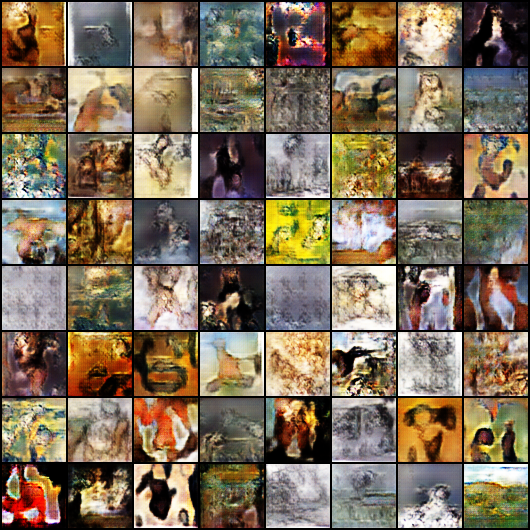

In [ ]:
Image('./generated/generated-images-0090.png')

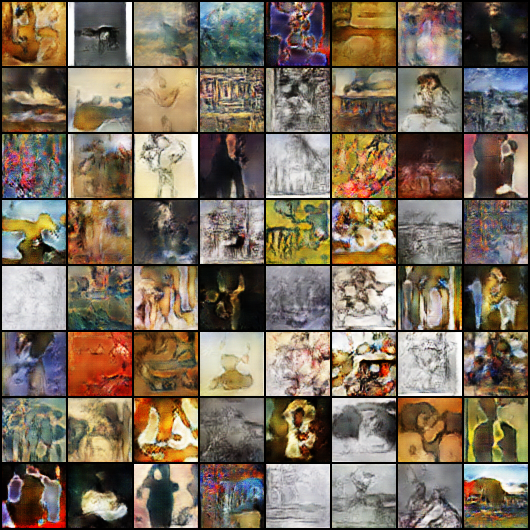

In [ ]:
Image('./generated/generated-images-0141.png')

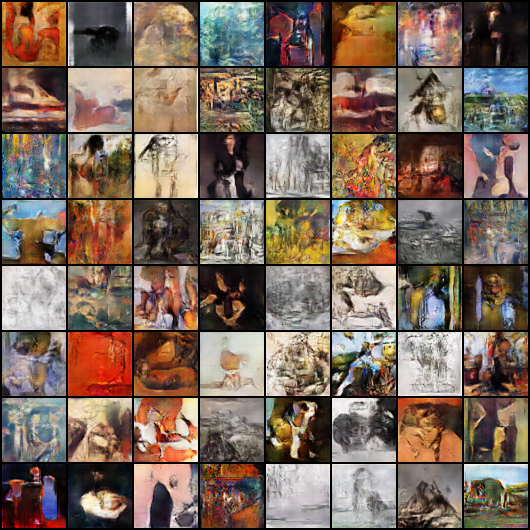

In [ ]:
Image('./generated/generated-images-0201.png')

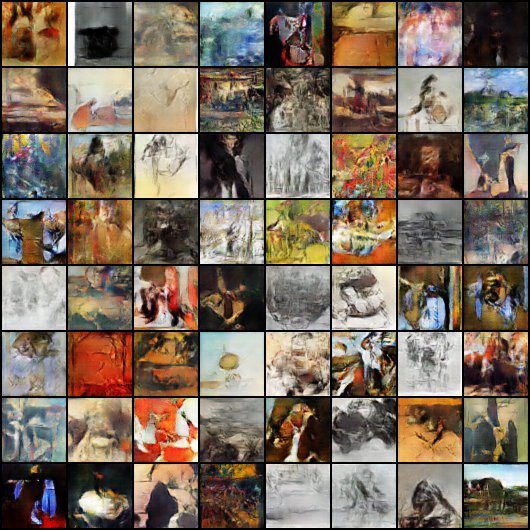

In [ ]:
Image('./generated/generated-images-0241.png')

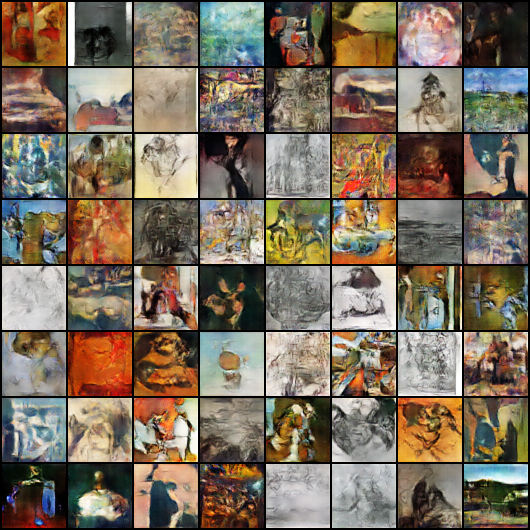

In [ ]:
Image('./generated/generated-images-0281.png')

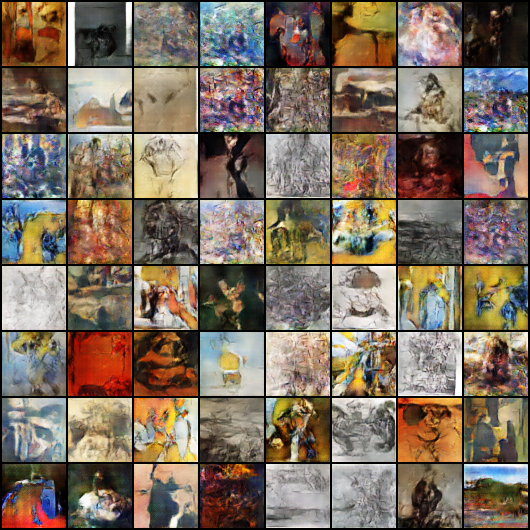

In [ ]:
Image('./generated/generated-images-0300.png')

#Results
1. Make a video on generative pictures.
2. Graphs

In [ ]:
import cv2
import os

vid_fname = 'art_gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 5, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

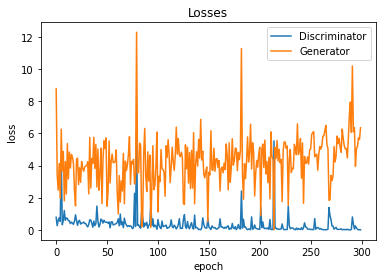

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

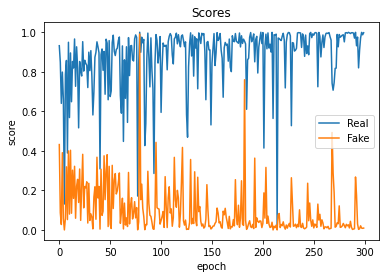

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

#Conclusion
Here we are seeing that the fake pictures quality is good but fake images prediction values are not very good.So now again we can run it using lower learning rate(lr) and near about 80-100 epoches may be able to increase the fake images prediction value.
 